## Fucheng Zhu CS542 Project Code
A program of 4 Keystroke Anomaly Detectors and their evaluation process

7/1/2022

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from scipy import spatial
from sklearn.svm import OneClassSVM

In [164]:
D = pd.read_csv('DSL-StrongPasswordData.csv')
detectors = ['Manhattan','Mahalanobis','Euclidean','SVM']
subjects = D[-D.duplicated('subject')]
subjects = subjects[['subject']]
subjects = np.array(subjects).T[0]

In [165]:
print(subjects)

['s002' 's003' 's004' 's005' 's007' 's008' 's010' 's011' 's012' 's013'
 's015' 's016' 's017' 's018' 's019' 's020' 's021' 's022' 's024' 's025'
 's026' 's027' 's028' 's029' 's030' 's031' 's032' 's033' 's034' 's035'
 's036' 's037' 's038' 's039' 's040' 's041' 's042' 's043' 's044' 's046'
 's047' 's048' 's049' 's050' 's051' 's052' 's053' 's054' 's055' 's056'
 's057']


## Anomaly Detectors

In [166]:
class ManhattanDetector:
    def __init__(self,YTrain):
        self.YScore = YTrain

    def train(self):
        mean_vector = np.mean(self.YScore,axis=0)
        return mean_vector
    
    def eval_test(self, mean_vector, YScore):
        n = YScore.shape[0]
        mean_matrix = np.array([mean_vector for _ in range(n)])
        scores = np.absolute(mean_matrix - YScore)
        return np.sum(scores,axis=1)

In [167]:
class MahalanobisDetector:
    def __init__(self,YTrain):
        self.YScore = YTrain

    def train(self):
        mean_vector = np.mean(self.YScore,axis=0)
        cov = np.cov(self.YScore.astype(float),rowvar=False)
        cov_inv = np.linalg.inv(cov)
        return [mean_vector,cov_inv]
        
    def eval_test(self, mean_vector, cov_inv, YScore):
        n = YScore.shape[0]
        scores = []
        for i in range(n):
            # print(YScore[i,:].shape)
            # print(mean_vector.shape)
            score = spatial.distance.mahalanobis(mean_vector,YScore[i,:],cov_inv)
            scores.append(score)
        return scores

In [168]:
class EuclideanDetector:
    def __init__(self,YTrain):
        self.YScore = YTrain

    def train(self):
        mean_vector = np.mean(self.YScore,axis=0)
        return mean_vector
    
    def eval_test(self, mean_vector, YScore):
        n,m = YScore.shape
        scores = []
        for i in range(n):
            score = np.linalg.norm((mean_vector- YScore[i,:]))
            scores.append(score)
        return scores

In [169]:
class SVM:
    def __init__(self,YTrain):
        self.YScore = YTrain
        self.svm = None
        
    def train(self):
        self.svm = OneClassSVM(kernel='rbf',gamma=0.001,nu = 0.5)
        self.svm.fit(self.YScore)
    
    def eval_test(self,YScore):
        scores = self.svm.predict(YScore)
        scores = self.svm.score_samples(YScore)
        # print('svm scores', scores)
        return scores


# ROC and AUC calculation function

In [170]:
def calculateROC(userScores, impostorScores):
    '''Taking in user scores and imposter scores and, coming up with a label vector based on them, calculate and show ROC'''
    predictions = np.append(userScores , impostorScores)
    predictions = np.nan_to_num(predictions,nan=0.01)

    # print('user',userScores.shape)

    labels = [0 for _ in range(len(userScores))] + [1 for _ in range(len(impostorScores))]
    pred = metrics.roc_curve(labels,predictions)
    
    fpr, tpr, thresholds = pred
    fnr = np.ones_like(fpr) - fpr
    tnr = np.ones_like(tpr) - tpr
    # print('fpr',fpr)
    # print('tpr',tpr)
    # print('thresholds',thresholds)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                        estimator_name='Detector')
    display.plot()
    plt.show()

    return roc_auc


# Evaluation Function

In [171]:
def evaluate(X,evalSubject,detector):
    '''For each detector, test the data for each subject'''
    assert(detector in detectors)
    YTrain = D[(D['sessionIndex'] <= 4 ) & (D['subject'] == evalSubject)]
    YTrain = np.array(YTrain)[:,3:]

    YScore0 = D[(D['sessionIndex'] > 4 ) & (D['subject'] == evalSubject)]
    YScore0 = np.array(YScore0)[:,3:]

    YScore1 = D[(D['sessionIndex'] == 1 ) & (D['subject'] != evalSubject) & (D['rep'] <= 5)]
    YScore1 = np.array(YScore1)[:,3:]
    
    if detector == 'Manhattan':
        m0 = ManhattanDetector(YTrain)
        mean_vector0 = m0.train()
        userScores0 = m0.eval_test(mean_vector0,YScore0)
        imposterScores0 = m0.eval_test(mean_vector0,YScore1)
        eer0 = calculateROC(userScores0, imposterScores0)
        return eer0
    elif detector == 'Mahalanobis':
        m1 = MahalanobisDetector(YTrain)
        mean_vector1, cov_inv = m1.train()
        userScores1 = m1.eval_test(mean_vector1, cov_inv, YScore0)
        imposterScores1 = m1.eval_test(mean_vector1, cov_inv, YScore1)
        eer1 = calculateROC(userScores1, imposterScores1)
        return eer1
    elif detector == 'Euclidean':
        m2 = EuclideanDetector(YTrain)
        mean_vector2 = m2.train()
        userScores2 = m2.eval_test(mean_vector2, YScore0)
        imposterScores2 = m2.eval_test(mean_vector2, YScore1)
        eer2 = calculateROC(userScores2, imposterScores2)
        return eer2
    elif detector == 'SVM':
        m3 = SVM(YTrain)
        m3.train()
        userScores3 = m3.eval_test(YScore0)
        imposterScores3 = m3.eval_test(YScore1)
        eer2 = calculateROC(userScores3, imposterScores3)
        return eer2
    return


# Main Procedure

In [172]:
def main():
    n = len(subjects)
    errors0 = []
    errors1 = []
    errors2 = []
    errors3 = []
    for i in range(n):
        print('Manhattan Detector Subject',subjects[i], '\n')
        error = evaluate(D,subjects[i],'Manhattan')
        if error != None:
            errors0.append(error)
    for j in range(n):
        print('Mahalanobis Detector Subject',subjects[j], '\n')
        error = evaluate(D,subjects[j],'Mahalanobis')
        if error != None:
            errors1.append(error)
    for k in range(n):
        print('Euclidean Detector Subject',subjects[k], '\n')
        error = evaluate(D,subjects[k],'Euclidean')
        if error != None:
            errors2.append(error)        
    for l in range(n):
        print('SVM Detector Subject',subjects[l], '\n')
        error = evaluate(D,subjects[l],'SVM')
        if error != None:
            errors3.append(error)    

    print('Manhattan Detector average AUC is:',np.mean(errors0))
    print('Mahalanobis Detector average AUC is:',np.mean(errors1))
    print('Eculidean Detector average AUC is:',np.mean(errors2))
    print('SVM Detector average AUC is:',np.mean(errors3))



        

Manhattan Detector Subject s002 



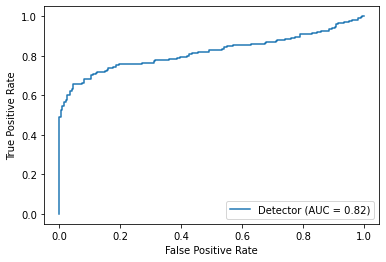

Manhattan Detector Subject s003 



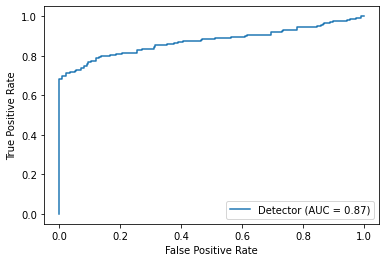

Manhattan Detector Subject s004 



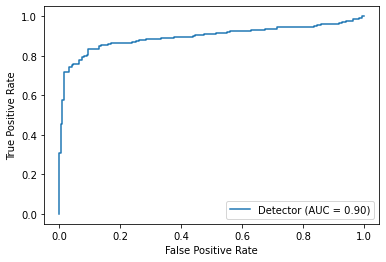

Manhattan Detector Subject s005 



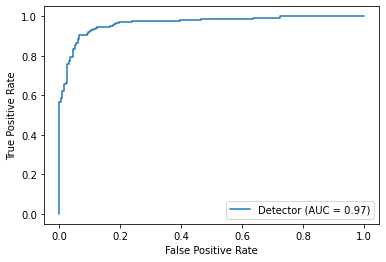

Manhattan Detector Subject s007 



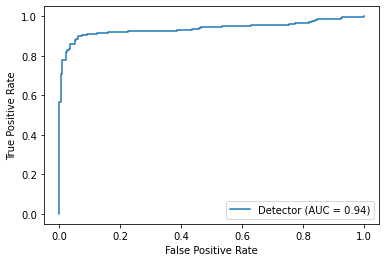

Manhattan Detector Subject s008 



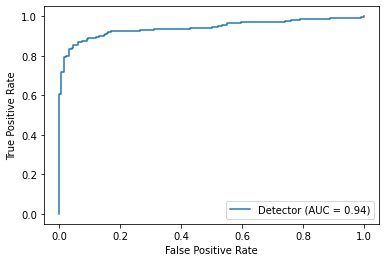

Manhattan Detector Subject s010 



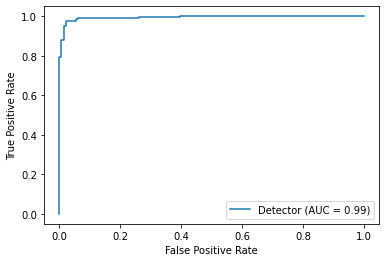

Manhattan Detector Subject s011 



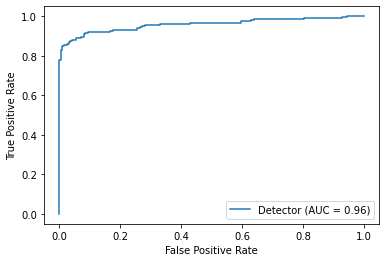

Manhattan Detector Subject s012 



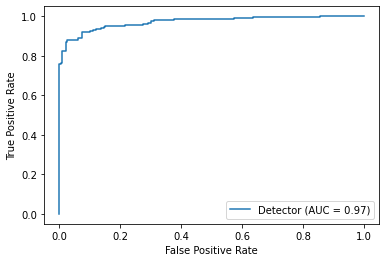

Manhattan Detector Subject s013 



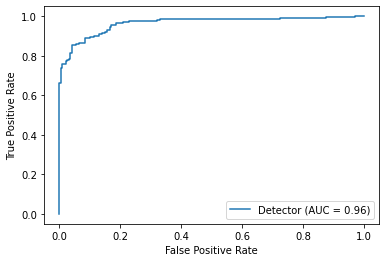

Manhattan Detector Subject s015 



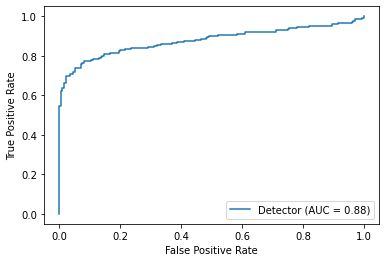

Manhattan Detector Subject s016 



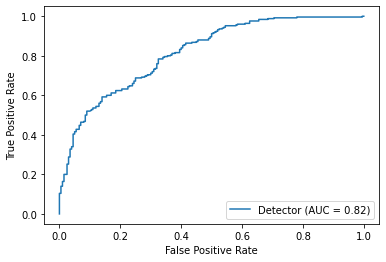

Manhattan Detector Subject s017 



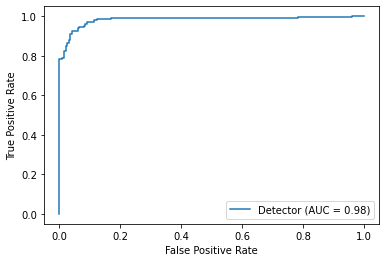

Manhattan Detector Subject s018 



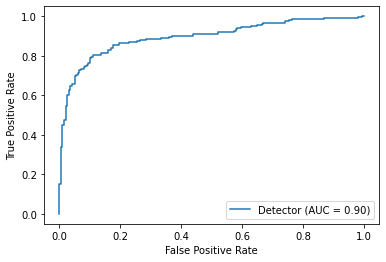

Manhattan Detector Subject s019 



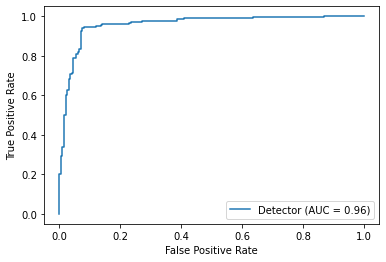

Manhattan Detector Subject s020 



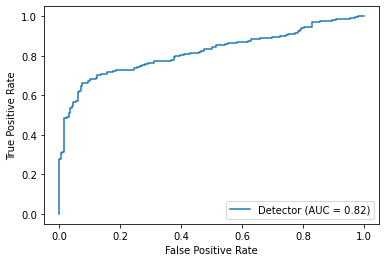

Manhattan Detector Subject s021 



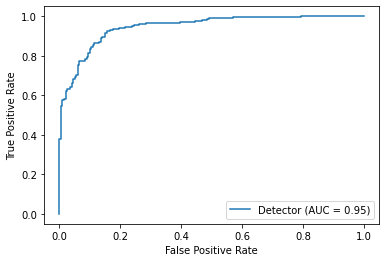

Manhattan Detector Subject s022 



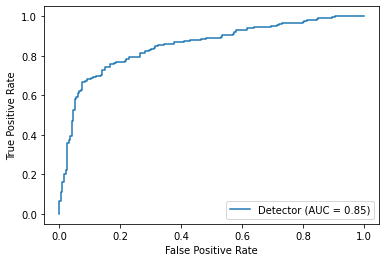

Manhattan Detector Subject s024 



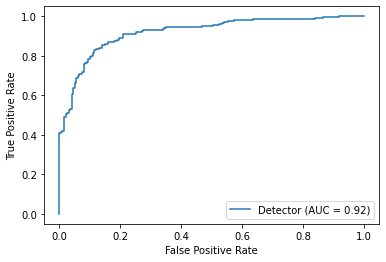

Manhattan Detector Subject s025 



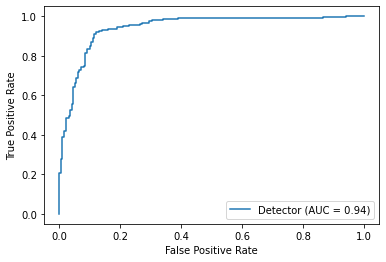

Manhattan Detector Subject s026 



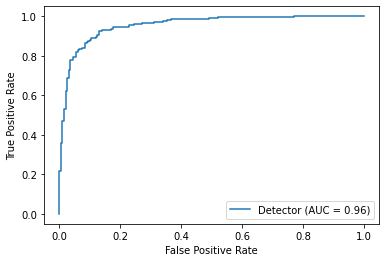

Manhattan Detector Subject s027 



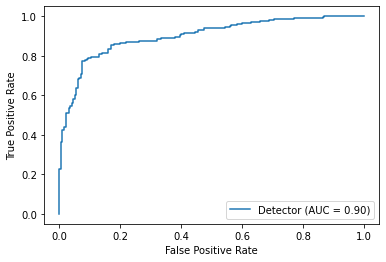

Manhattan Detector Subject s028 



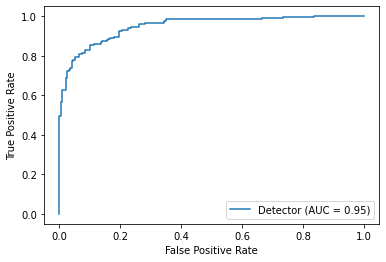

Manhattan Detector Subject s029 



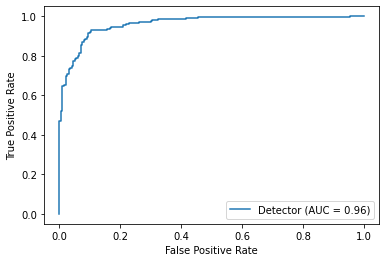

Manhattan Detector Subject s030 



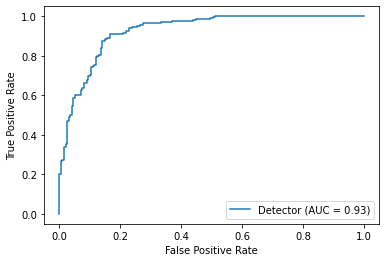

Manhattan Detector Subject s031 



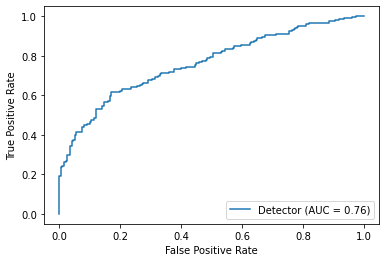

Manhattan Detector Subject s032 



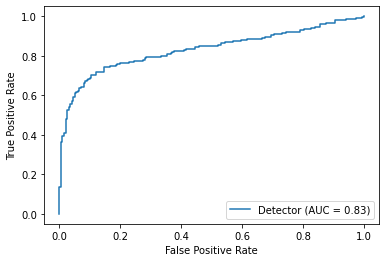

Manhattan Detector Subject s033 



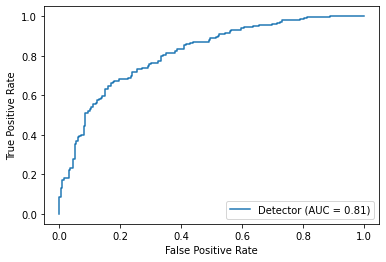

Manhattan Detector Subject s034 



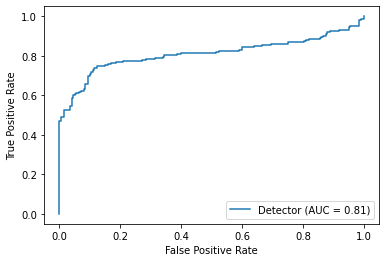

Manhattan Detector Subject s035 



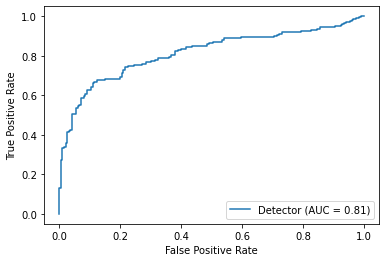

Manhattan Detector Subject s036 



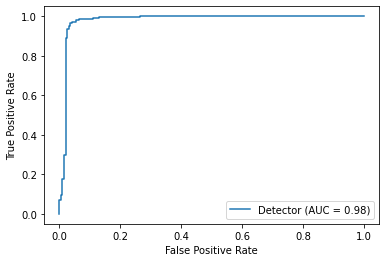

Manhattan Detector Subject s037 



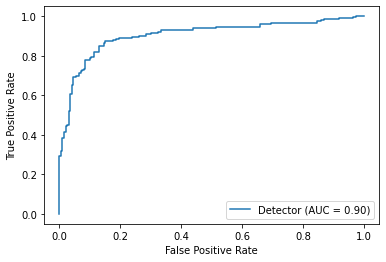

Manhattan Detector Subject s038 



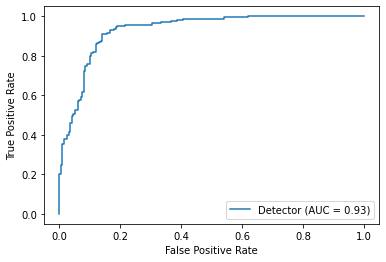

Manhattan Detector Subject s039 



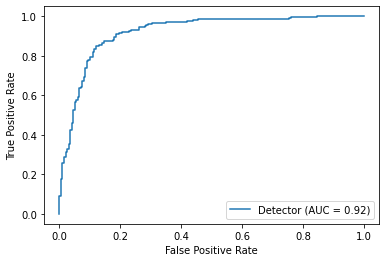

Manhattan Detector Subject s040 



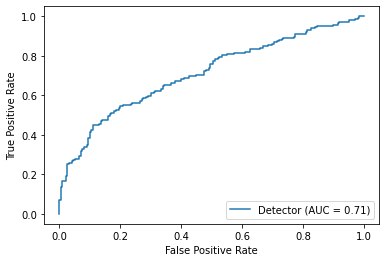

Manhattan Detector Subject s041 



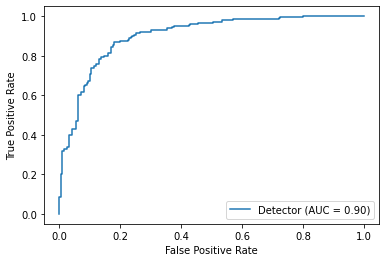

Manhattan Detector Subject s042 



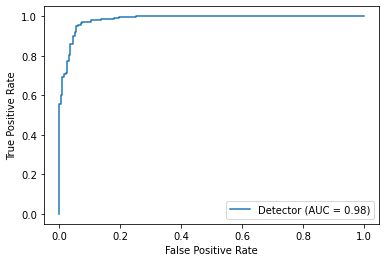

Manhattan Detector Subject s043 



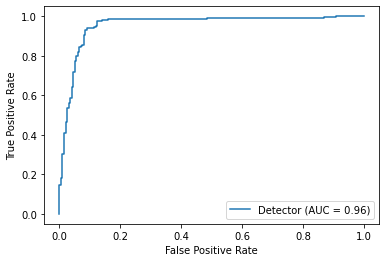

Manhattan Detector Subject s044 



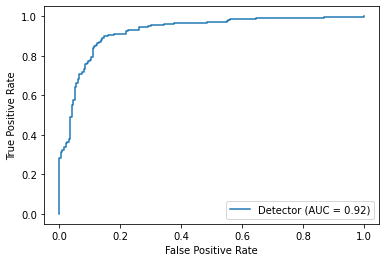

Manhattan Detector Subject s046 



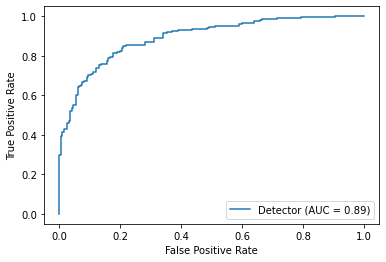

Manhattan Detector Subject s047 



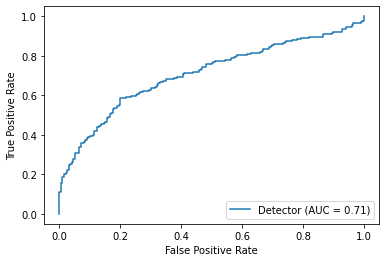

Manhattan Detector Subject s048 



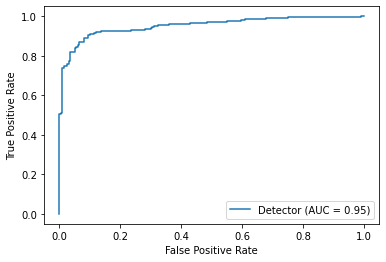

Manhattan Detector Subject s049 



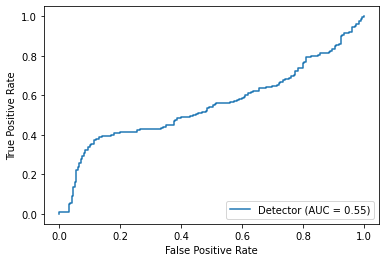

Manhattan Detector Subject s050 



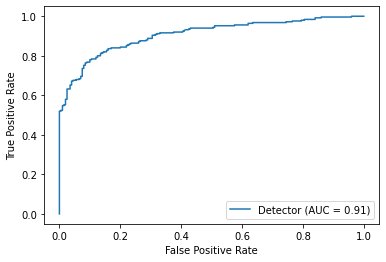

Manhattan Detector Subject s051 



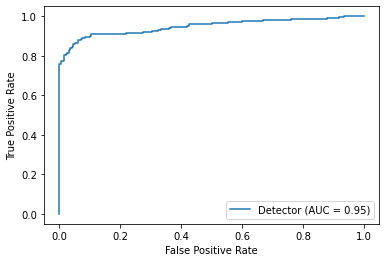

Manhattan Detector Subject s052 



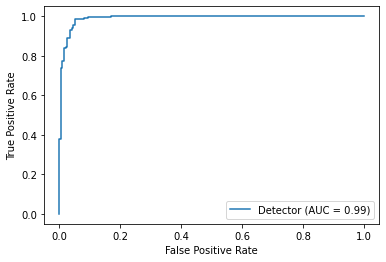

Manhattan Detector Subject s053 



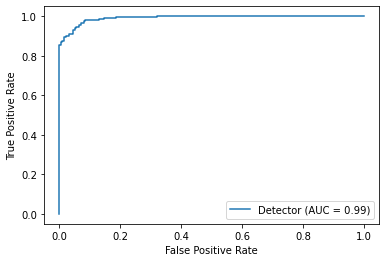

Manhattan Detector Subject s054 



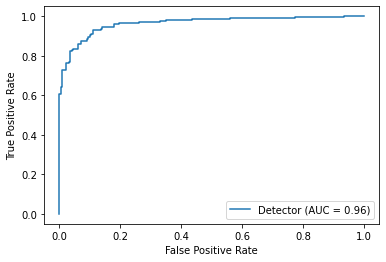

Manhattan Detector Subject s055 



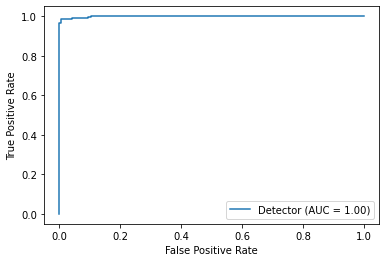

Manhattan Detector Subject s056 



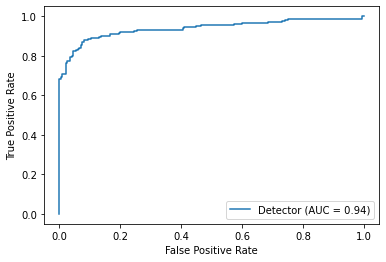

Manhattan Detector Subject s057 



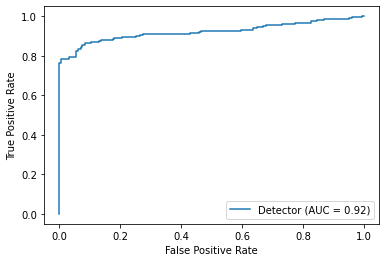

Mahalanobis Detector Subject s002 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


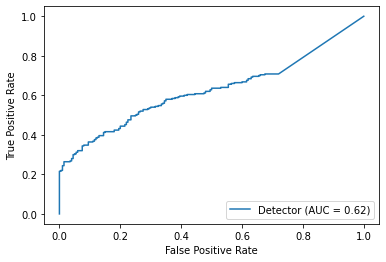

Mahalanobis Detector Subject s003 



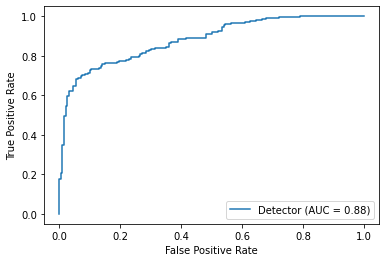

Mahalanobis Detector Subject s004 



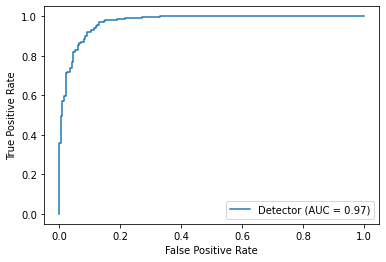

Mahalanobis Detector Subject s005 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


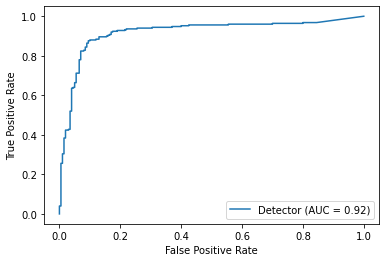

Mahalanobis Detector Subject s007 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


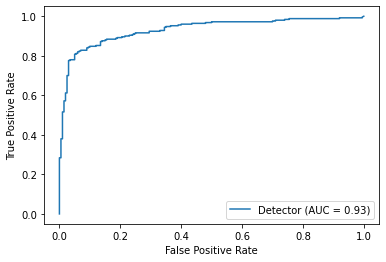

Mahalanobis Detector Subject s008 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


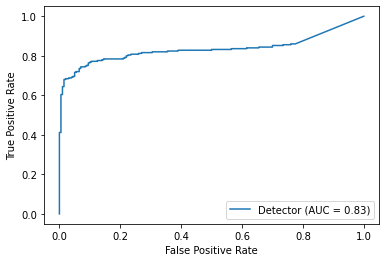

Mahalanobis Detector Subject s010 



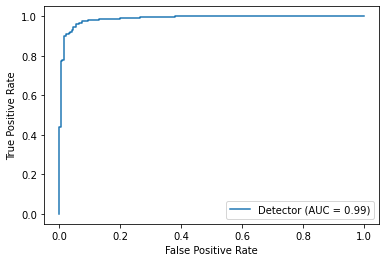

Mahalanobis Detector Subject s011 



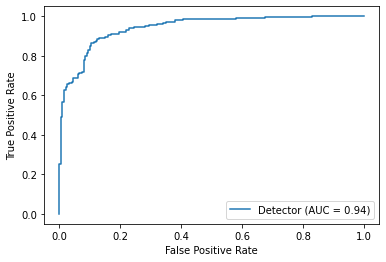

Mahalanobis Detector Subject s012 



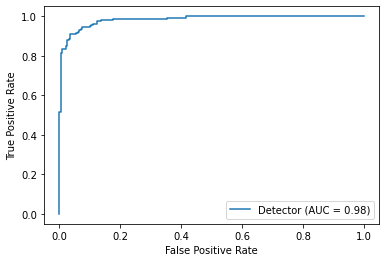

Mahalanobis Detector Subject s013 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


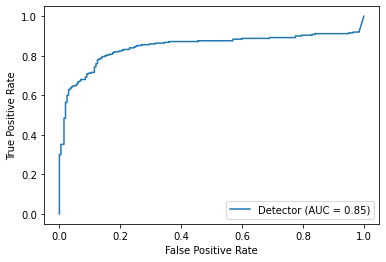

Mahalanobis Detector Subject s015 



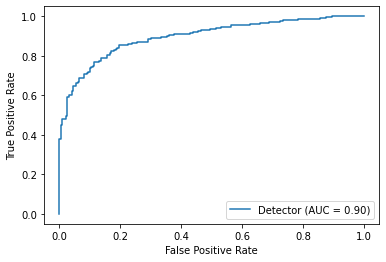

Mahalanobis Detector Subject s016 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


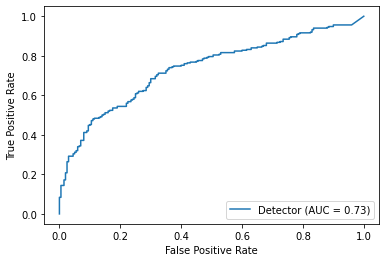

Mahalanobis Detector Subject s017 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


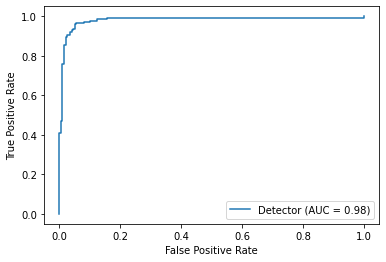

Mahalanobis Detector Subject s018 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


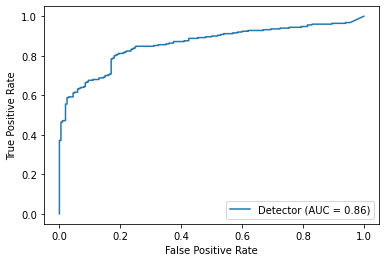

Mahalanobis Detector Subject s019 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


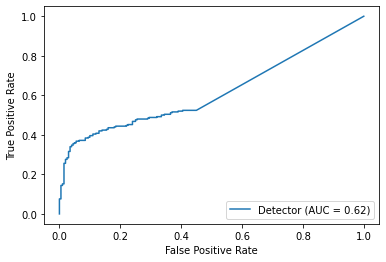

Mahalanobis Detector Subject s020 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


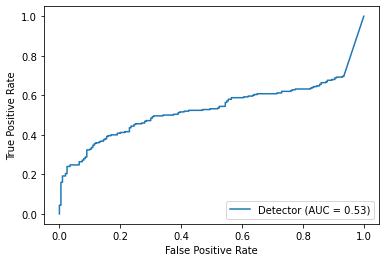

Mahalanobis Detector Subject s021 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


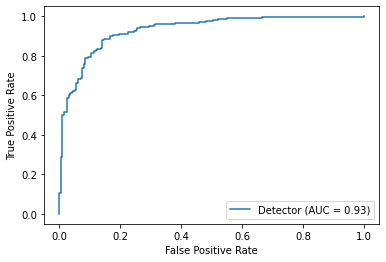

Mahalanobis Detector Subject s022 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


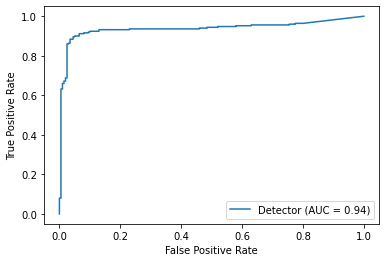

Mahalanobis Detector Subject s024 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


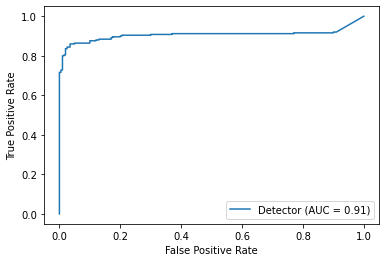

Mahalanobis Detector Subject s025 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


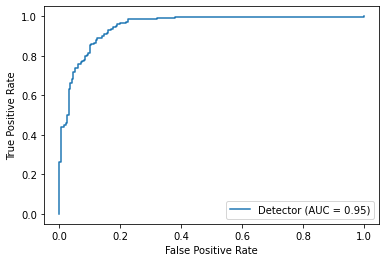

Mahalanobis Detector Subject s026 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


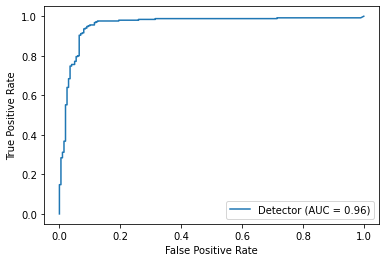

Mahalanobis Detector Subject s027 



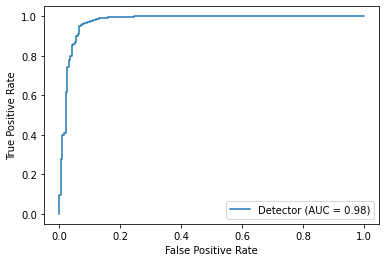

Mahalanobis Detector Subject s028 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


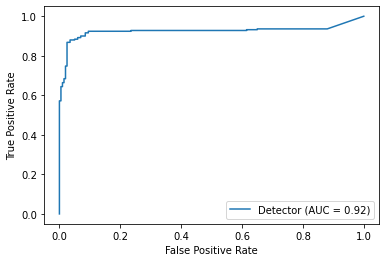

Mahalanobis Detector Subject s029 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


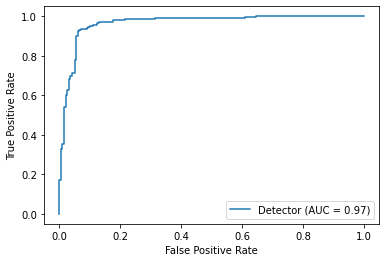

Mahalanobis Detector Subject s030 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


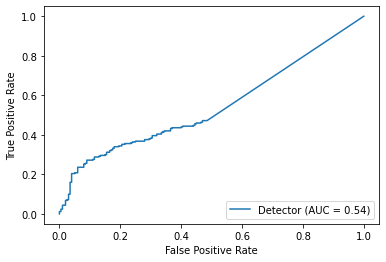

Mahalanobis Detector Subject s031 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


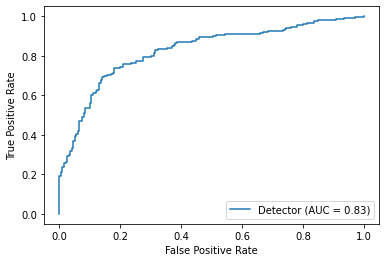

Mahalanobis Detector Subject s032 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


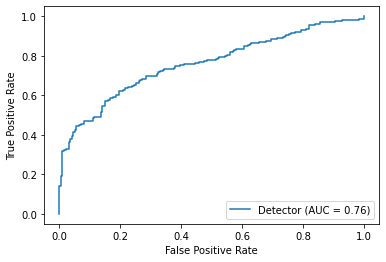

Mahalanobis Detector Subject s033 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


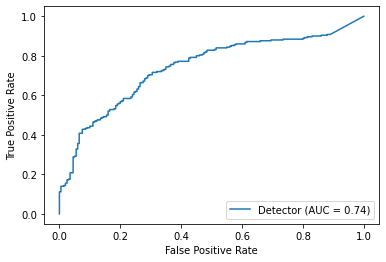

Mahalanobis Detector Subject s034 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


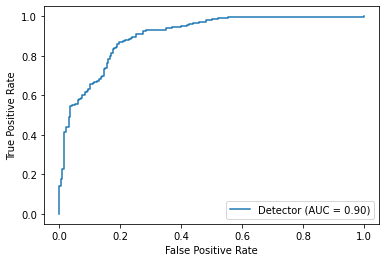

Mahalanobis Detector Subject s035 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


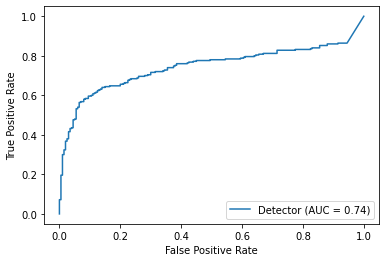

Mahalanobis Detector Subject s036 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


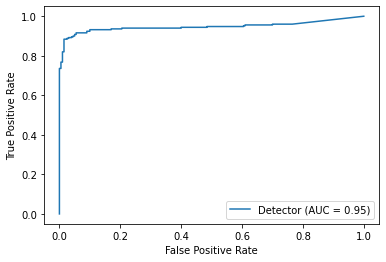

Mahalanobis Detector Subject s037 



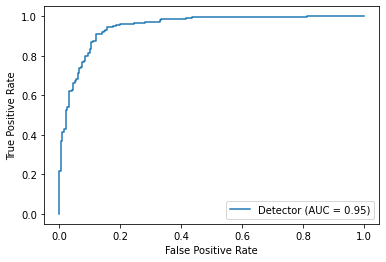

Mahalanobis Detector Subject s038 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


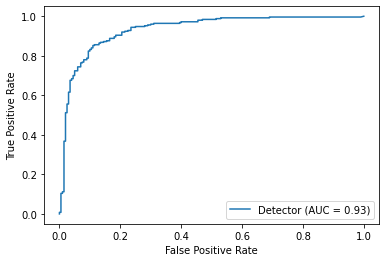

Mahalanobis Detector Subject s039 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


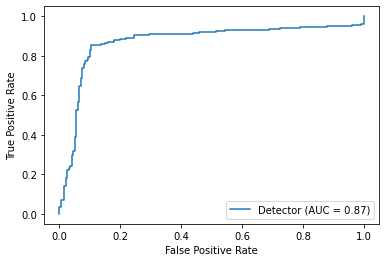

Mahalanobis Detector Subject s040 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


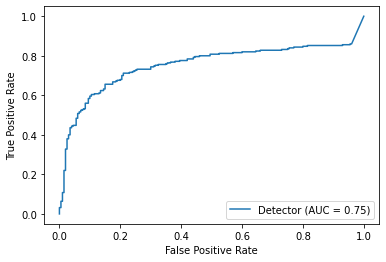

Mahalanobis Detector Subject s041 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


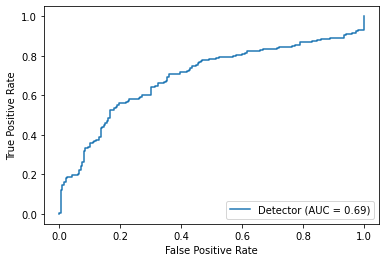

Mahalanobis Detector Subject s042 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


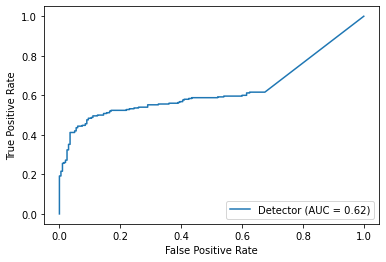

Mahalanobis Detector Subject s043 



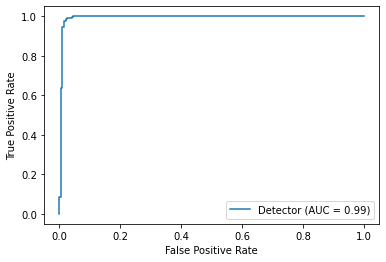

Mahalanobis Detector Subject s044 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


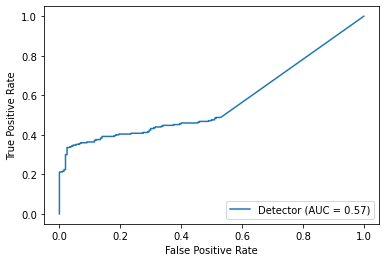

Mahalanobis Detector Subject s046 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


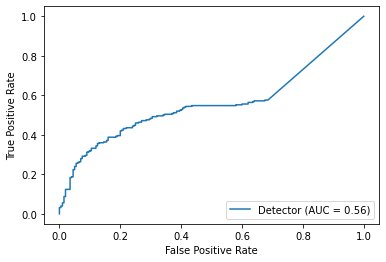

Mahalanobis Detector Subject s047 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


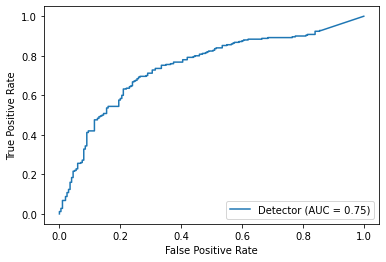

Mahalanobis Detector Subject s048 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


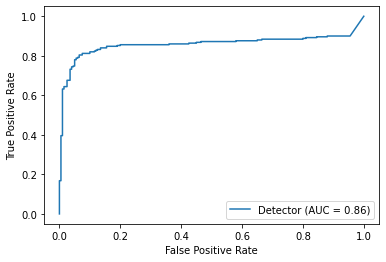

Mahalanobis Detector Subject s049 



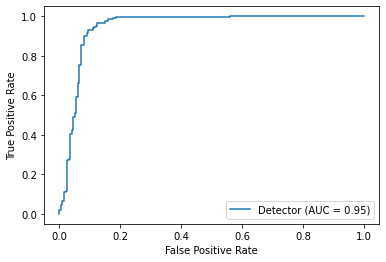

Mahalanobis Detector Subject s050 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


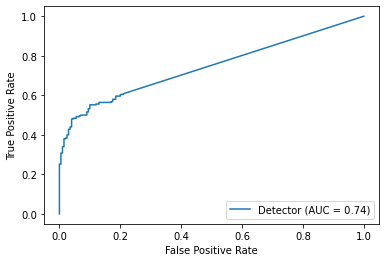

Mahalanobis Detector Subject s051 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


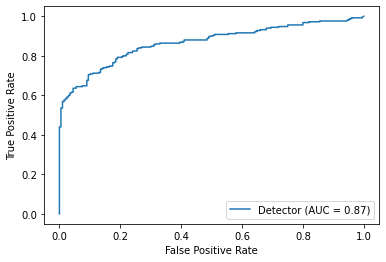

Mahalanobis Detector Subject s052 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


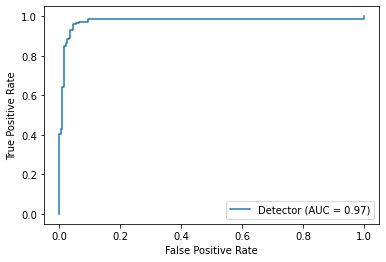

Mahalanobis Detector Subject s053 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


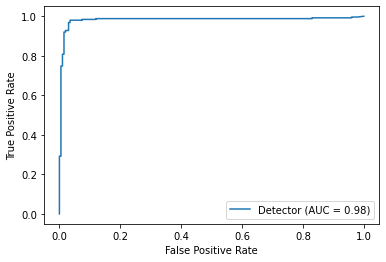

Mahalanobis Detector Subject s054 



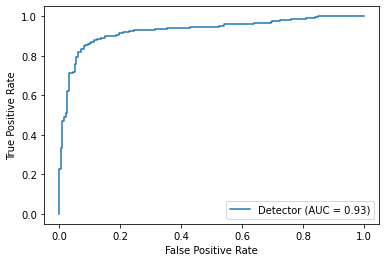

Mahalanobis Detector Subject s055 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


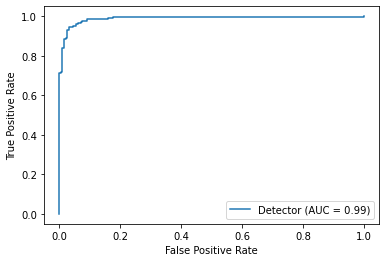

Mahalanobis Detector Subject s056 



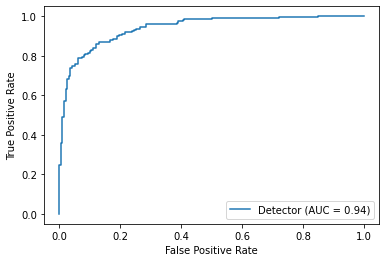

Mahalanobis Detector Subject s057 



/Users/rockuser/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:1065: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


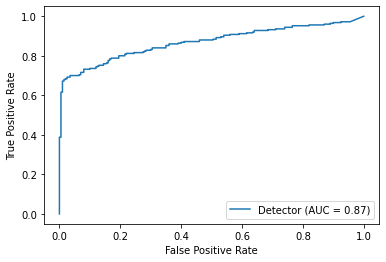

Euclidean Detector Subject s002 



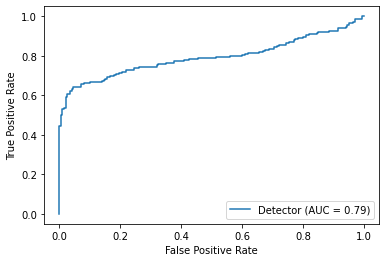

Euclidean Detector Subject s003 



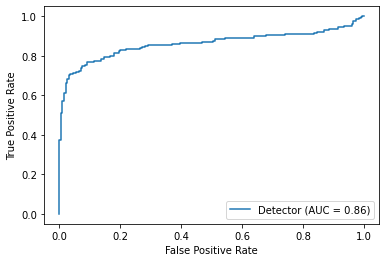

Euclidean Detector Subject s004 



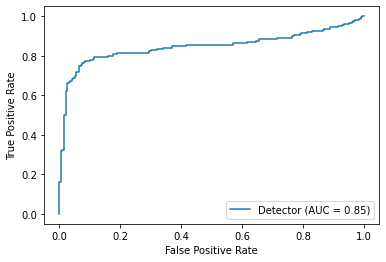

Euclidean Detector Subject s005 



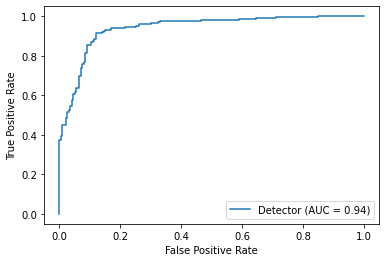

Euclidean Detector Subject s007 



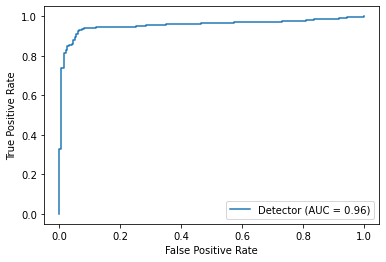

Euclidean Detector Subject s008 



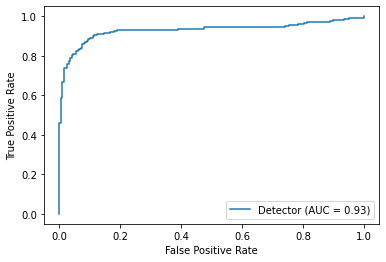

Euclidean Detector Subject s010 



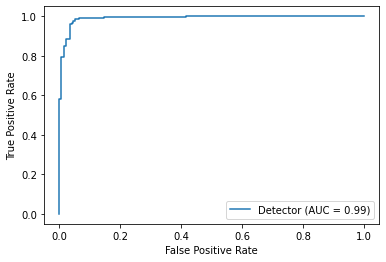

Euclidean Detector Subject s011 



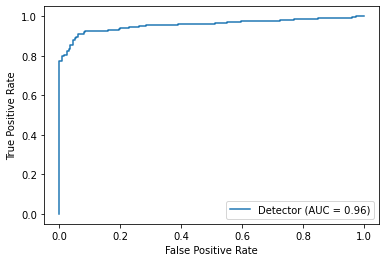

Euclidean Detector Subject s012 



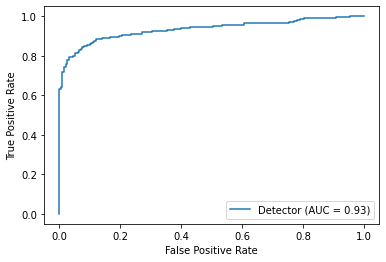

Euclidean Detector Subject s013 



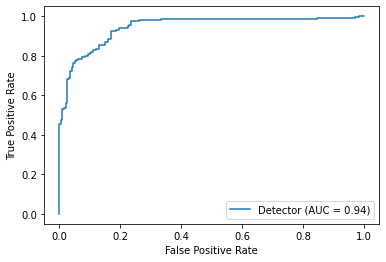

Euclidean Detector Subject s015 



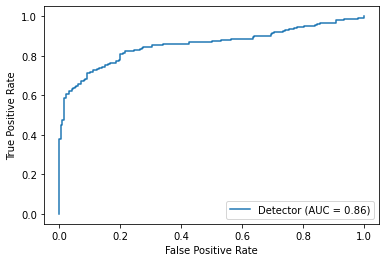

Euclidean Detector Subject s016 



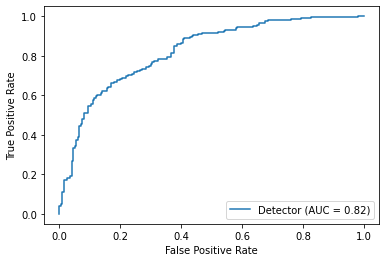

Euclidean Detector Subject s017 



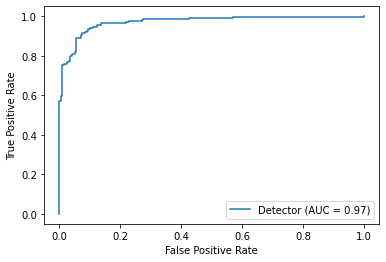

Euclidean Detector Subject s018 



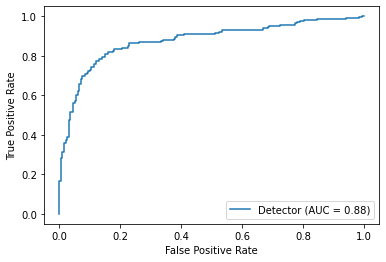

Euclidean Detector Subject s019 



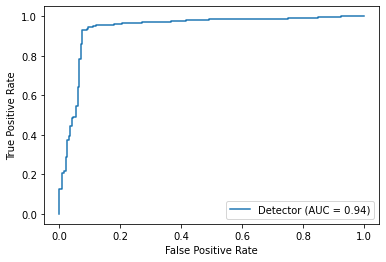

Euclidean Detector Subject s020 



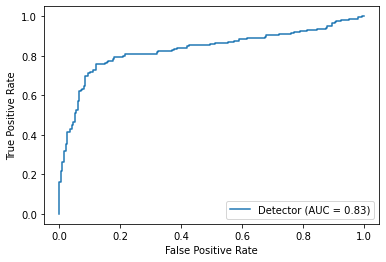

Euclidean Detector Subject s021 



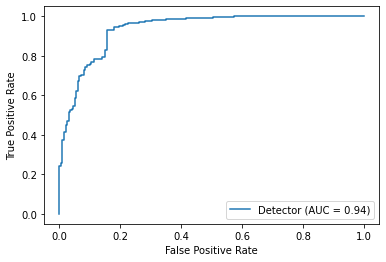

Euclidean Detector Subject s022 



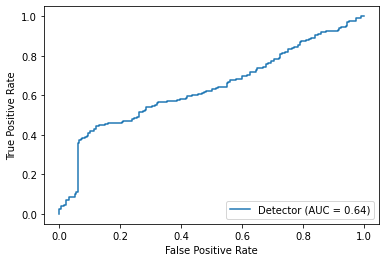

Euclidean Detector Subject s024 



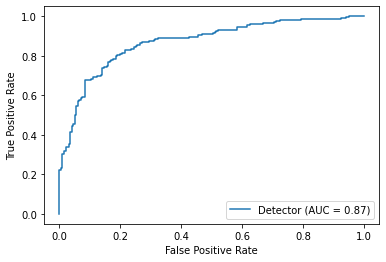

Euclidean Detector Subject s025 



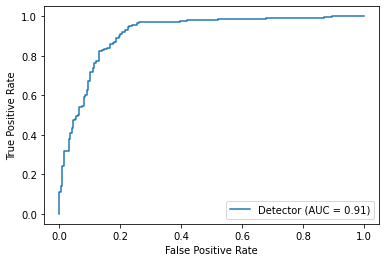

Euclidean Detector Subject s026 



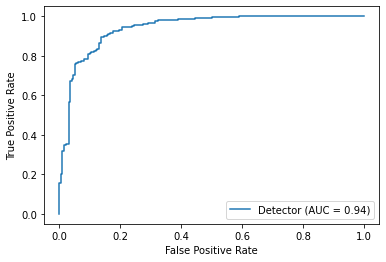

Euclidean Detector Subject s027 



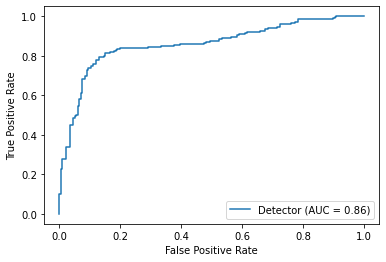

Euclidean Detector Subject s028 



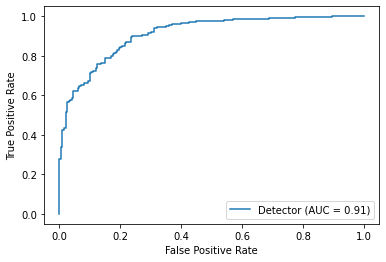

Euclidean Detector Subject s029 



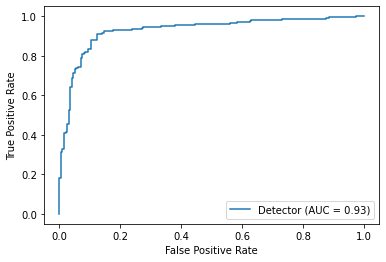

Euclidean Detector Subject s030 



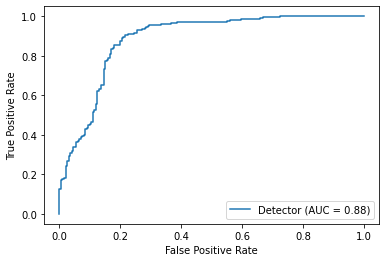

Euclidean Detector Subject s031 



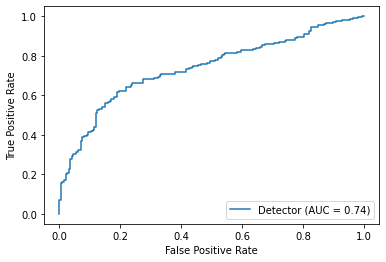

Euclidean Detector Subject s032 



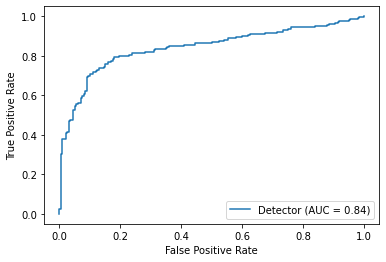

Euclidean Detector Subject s033 



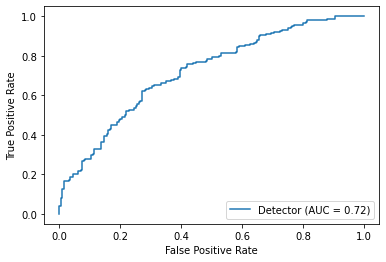

Euclidean Detector Subject s034 



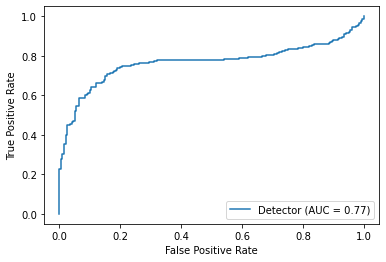

Euclidean Detector Subject s035 



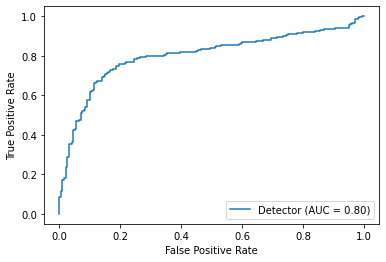

Euclidean Detector Subject s036 



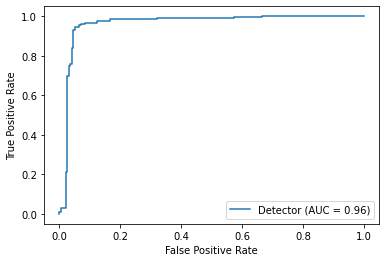

Euclidean Detector Subject s037 



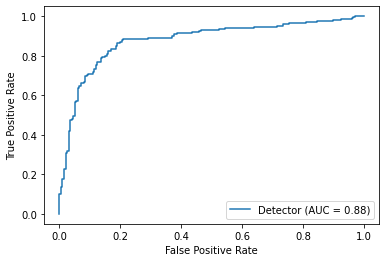

Euclidean Detector Subject s038 



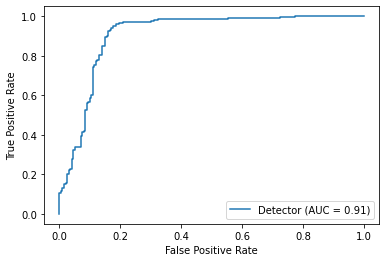

Euclidean Detector Subject s039 



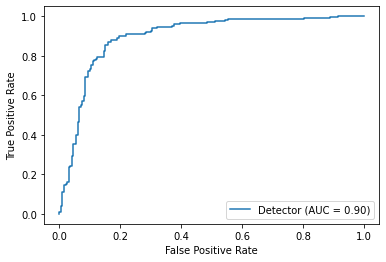

Euclidean Detector Subject s040 



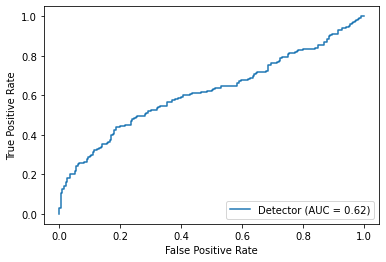

Euclidean Detector Subject s041 



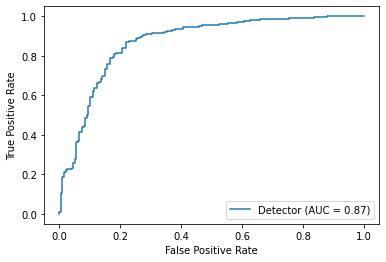

Euclidean Detector Subject s042 



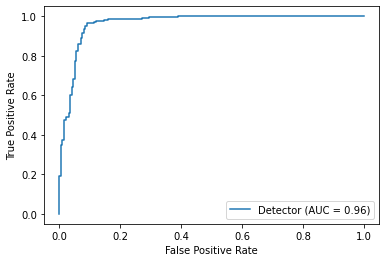

Euclidean Detector Subject s043 



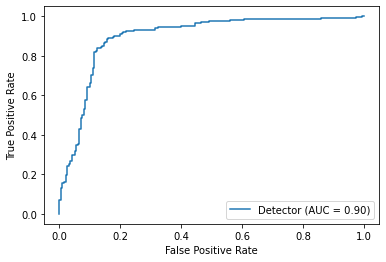

Euclidean Detector Subject s044 



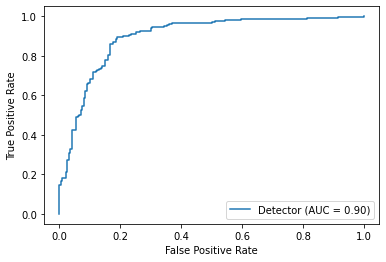

Euclidean Detector Subject s046 



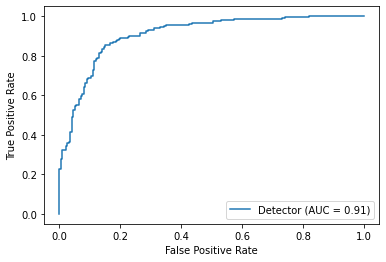

Euclidean Detector Subject s047 



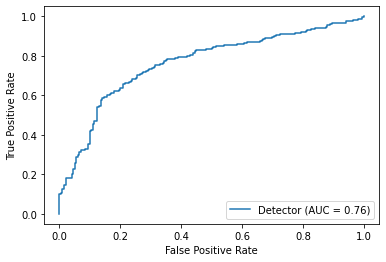

Euclidean Detector Subject s048 



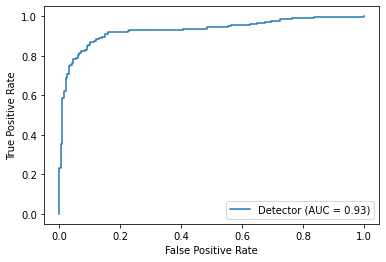

Euclidean Detector Subject s049 



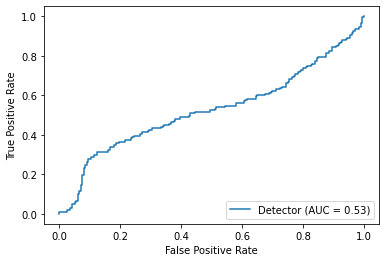

Euclidean Detector Subject s050 



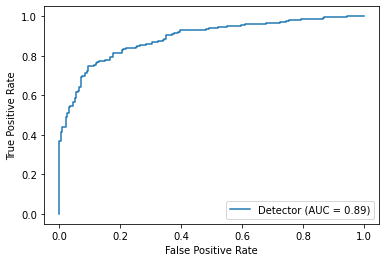

Euclidean Detector Subject s051 



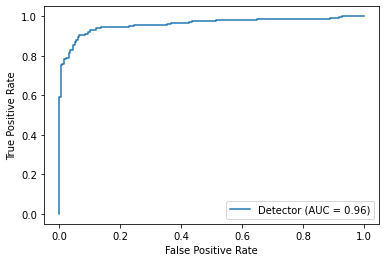

Euclidean Detector Subject s052 



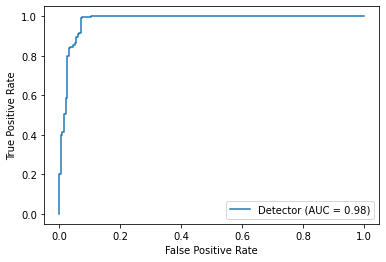

Euclidean Detector Subject s053 



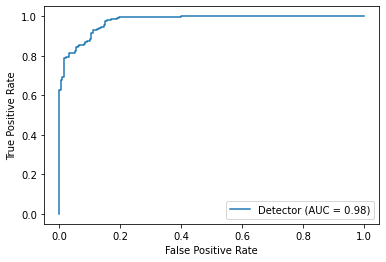

Euclidean Detector Subject s054 



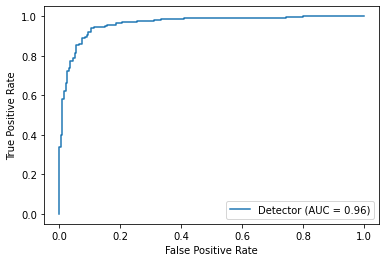

Euclidean Detector Subject s055 



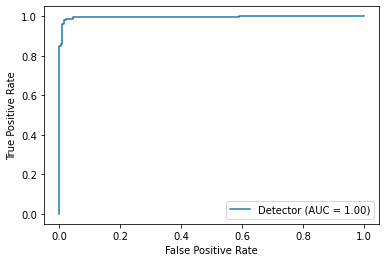

Euclidean Detector Subject s056 



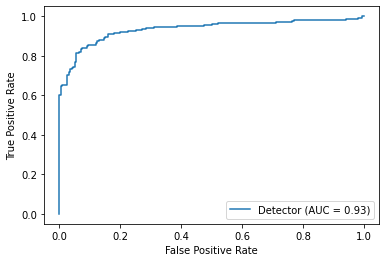

Euclidean Detector Subject s057 



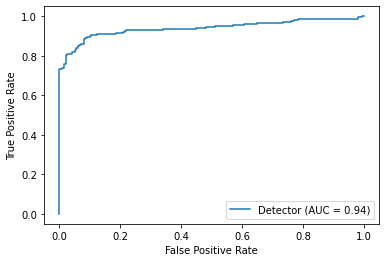

SVM Detector Subject s002 



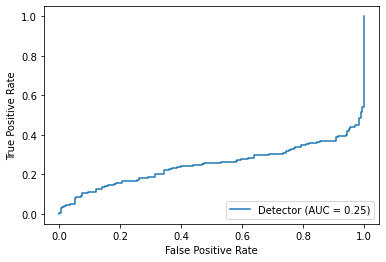

SVM Detector Subject s003 



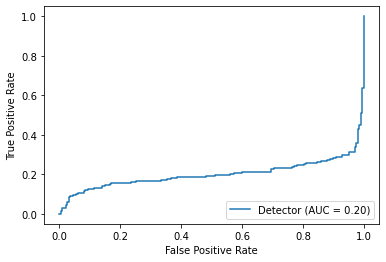

SVM Detector Subject s004 



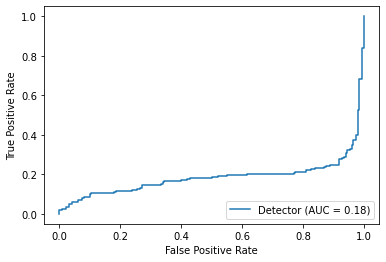

SVM Detector Subject s005 



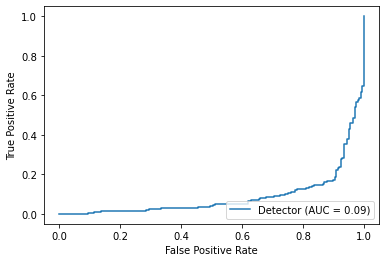

SVM Detector Subject s007 



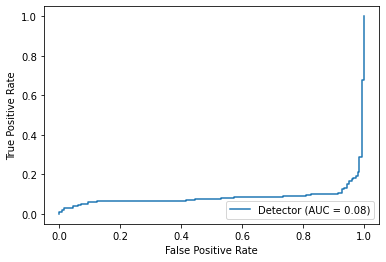

SVM Detector Subject s008 



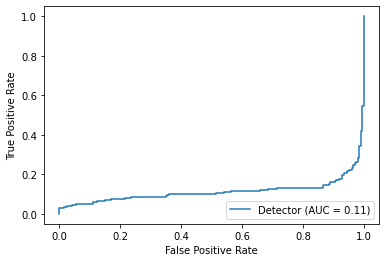

SVM Detector Subject s010 



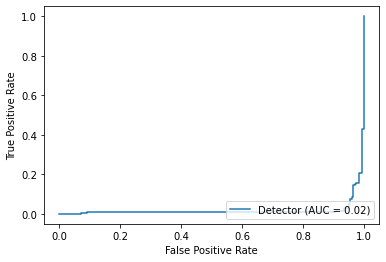

SVM Detector Subject s011 



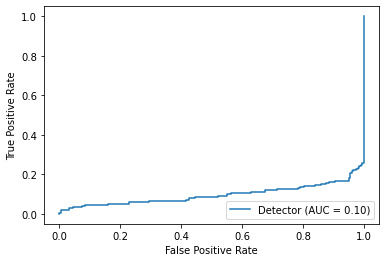

SVM Detector Subject s012 



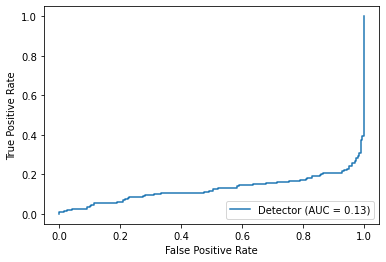

SVM Detector Subject s013 



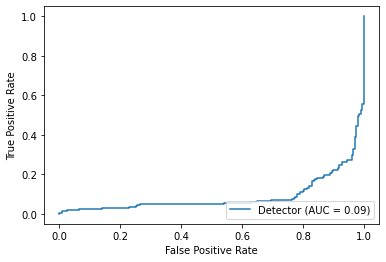

SVM Detector Subject s015 



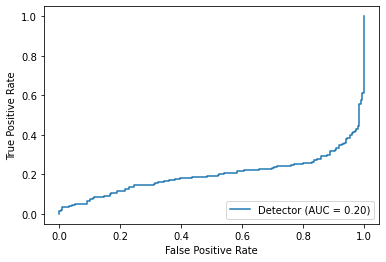

SVM Detector Subject s016 



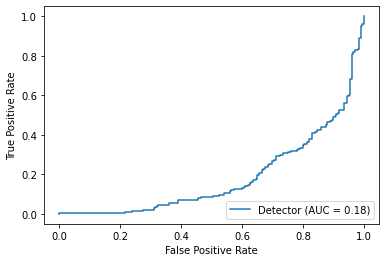

SVM Detector Subject s017 



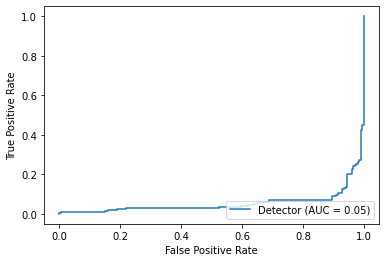

SVM Detector Subject s018 



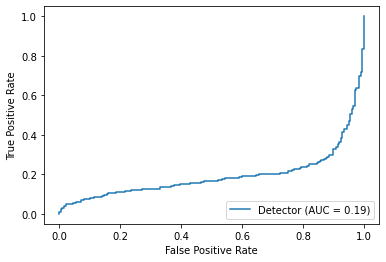

SVM Detector Subject s019 



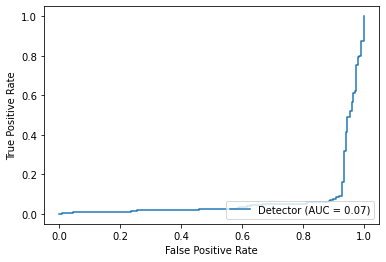

SVM Detector Subject s020 



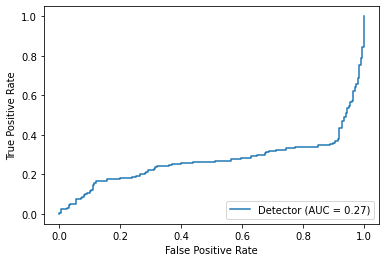

SVM Detector Subject s021 



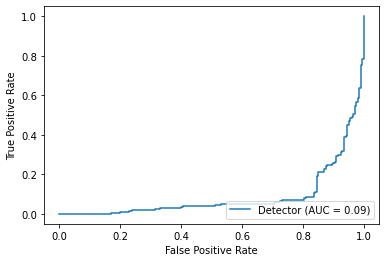

SVM Detector Subject s022 



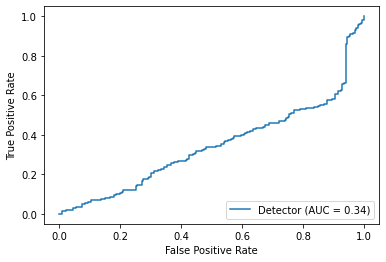

SVM Detector Subject s024 



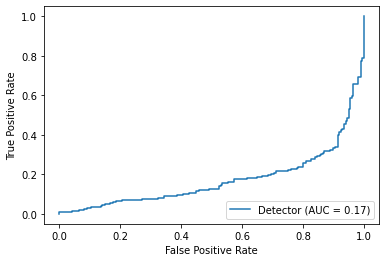

SVM Detector Subject s025 



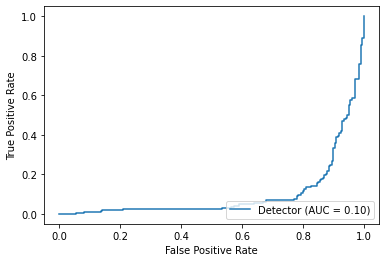

SVM Detector Subject s026 



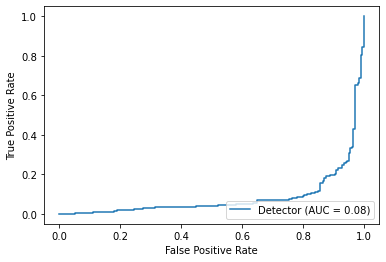

SVM Detector Subject s027 



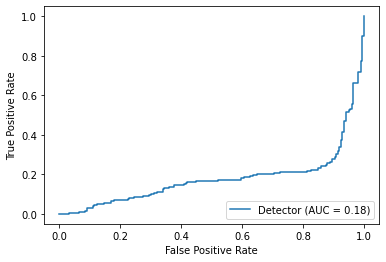

SVM Detector Subject s028 



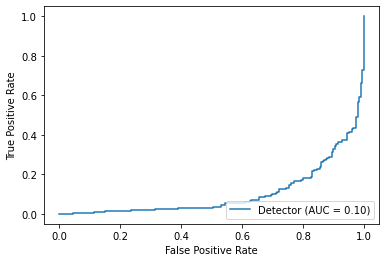

SVM Detector Subject s029 



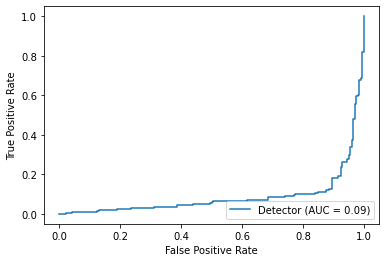

SVM Detector Subject s030 



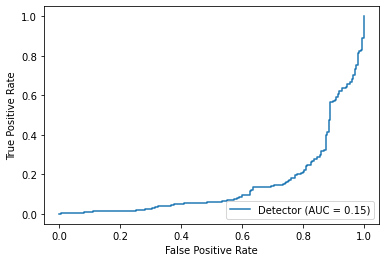

SVM Detector Subject s031 



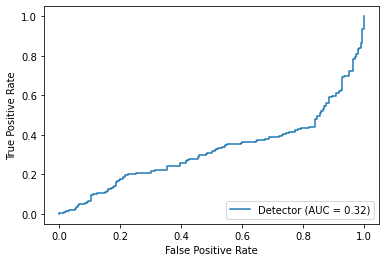

SVM Detector Subject s032 



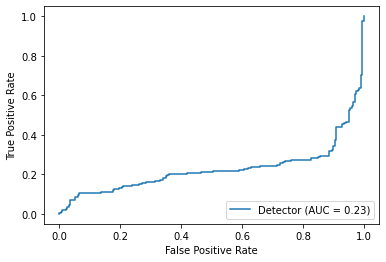

SVM Detector Subject s033 



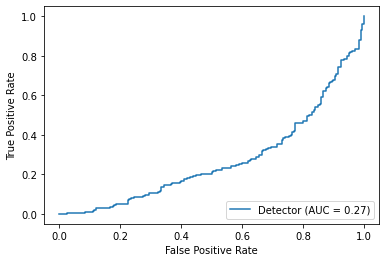

SVM Detector Subject s034 



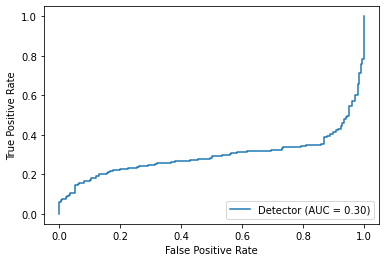

SVM Detector Subject s035 



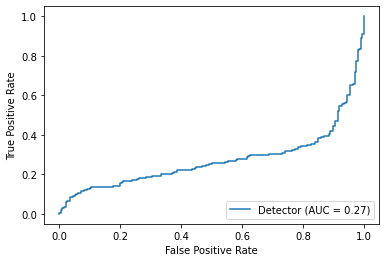

SVM Detector Subject s036 



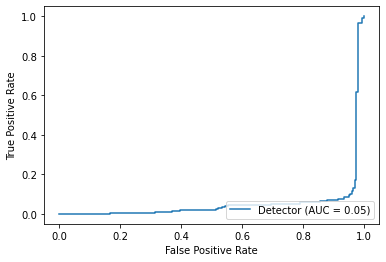

SVM Detector Subject s037 



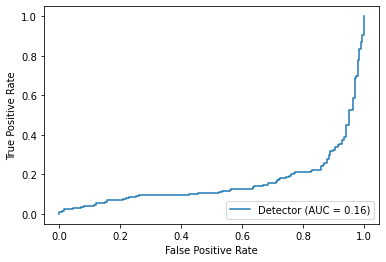

SVM Detector Subject s038 



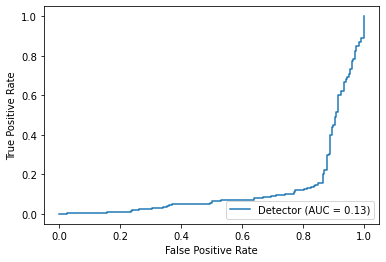

SVM Detector Subject s039 



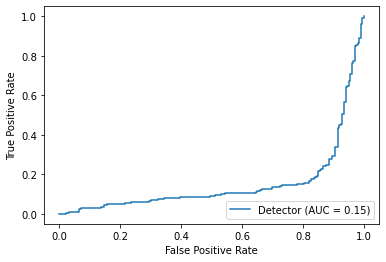

SVM Detector Subject s040 



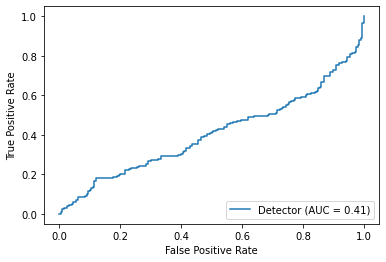

SVM Detector Subject s041 



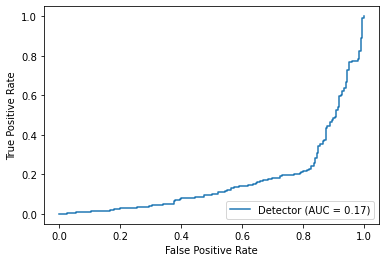

SVM Detector Subject s042 



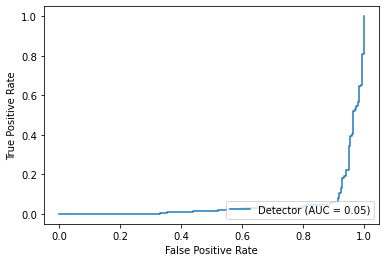

SVM Detector Subject s043 



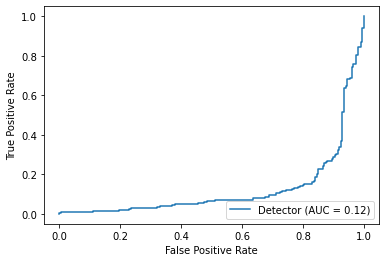

SVM Detector Subject s044 



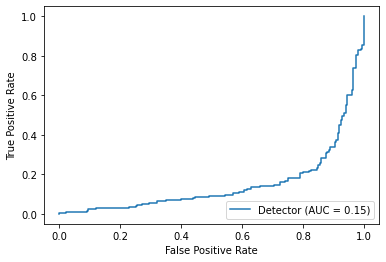

SVM Detector Subject s046 



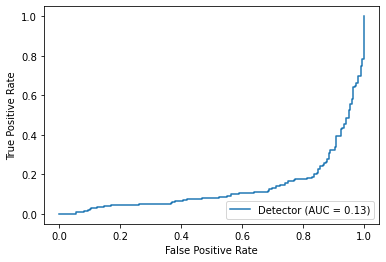

SVM Detector Subject s047 



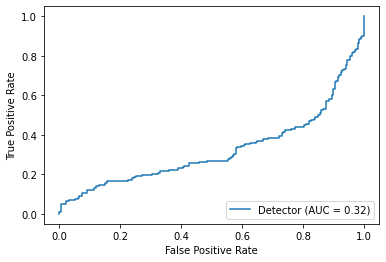

SVM Detector Subject s048 



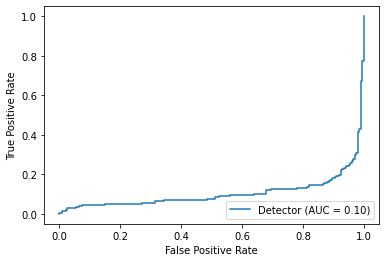

SVM Detector Subject s049 



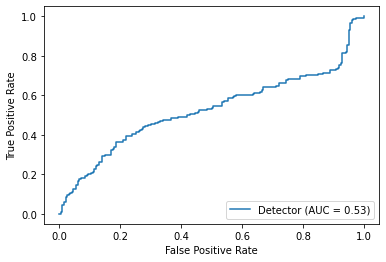

SVM Detector Subject s050 



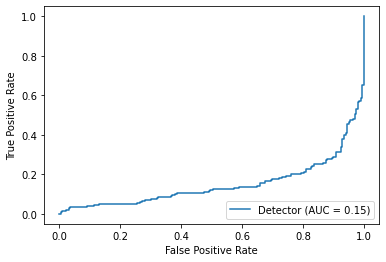

SVM Detector Subject s051 



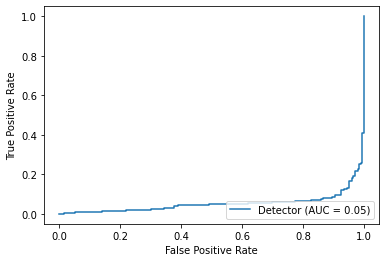

SVM Detector Subject s052 



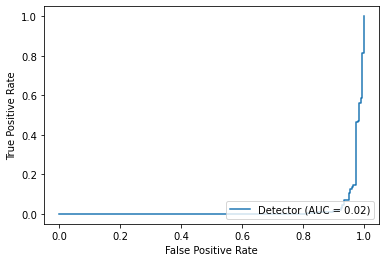

SVM Detector Subject s053 



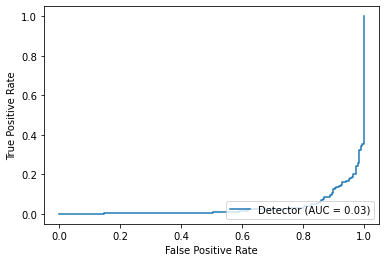

SVM Detector Subject s054 



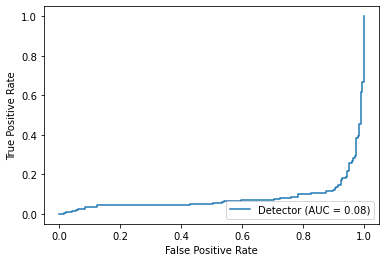

SVM Detector Subject s055 



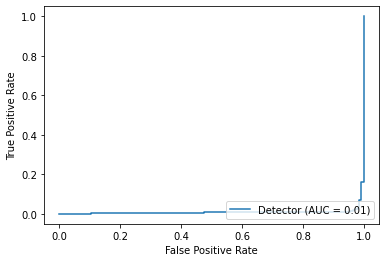

SVM Detector Subject s056 



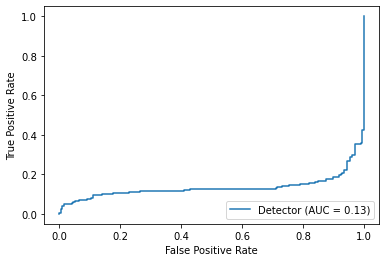

SVM Detector Subject s057 



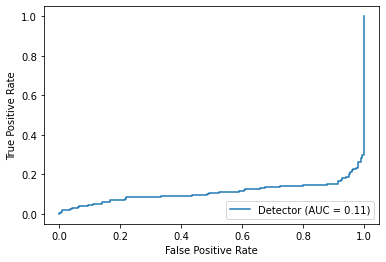

Manhattan Detector average AUC is: 0.9026227450980392
Mahalanobis Detector average AUC is: 0.8496001960784313
Eculidean Detector average AUC is: 0.8793352941176469
SVM Detector average AUC is: 0.1559905882352941


In [173]:
main()